### Importaci√≥n de Librer√≠as necesarias

In [1]:
import os
import zipfile
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Masking, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


### 1. Importaci√≥n de datos desde Github (Datos tomados con Edge Impulse)

Descarga y descompresi√≥n de un archivo .zip desde el repositorio de GitHub. El archivo contiene los datos recolectados mediante Edge Impulse, que ser√°n utilizados posteriormente para entrenar modelos de clasificaci√≥n de series de tiempo. Se maneja la operaci√≥n con un bloque try-except para capturar y reportar posibles errores en la descarga o extracci√≥n.

In [2]:
# URL del archivo ZIP en GitHub que contiene los datos exportados desde Edge Impulse
GITHUB_URL = "https://github.com/DCajiao/Time-Series-Classification-with-Recurrent-Networks/raw/main/data/zip/dcajiao-project-1-export.zip"

# Nombre local con el que se guardar√° el archivo ZIP una vez descargado
zip_path = "dcajiao-project-1-export.zip"

try:
    # Realiza una petici√≥n HTTP para descargar el contenido del archivo desde GitHub
    response = requests.get(GITHUB_URL)

    # Guarda el contenido descargado en un archivo ZIP localmente
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Descomprime el archivo ZIP en una carpeta llamada 'data'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("data")  # Extrae todos los archivos en la ruta especificada
        print("Archivo descargado y descomprimido en la carpeta 'data'.")

# Captura cualquier error que ocurra durante la descarga o descompresi√≥n e imprime el mensaje
except Exception as e:
    print(f"Error al descargar o descomprimir el archivo: {e}")


Archivo descargado y descomprimido en la carpeta 'data'.


### 2. Carga de Datos

1. **Lectura de archivos `.labels`** generados por Edge Impulse, que contienen informaci√≥n sobre las muestras recolectadas.
2. **Funci√≥n `load_samples()`**:

   * Lee cada muestra `.json` asociada a su etiqueta.
   * Convierte las secuencias de datos en arreglos NumPy.
   * Mapea las etiquetas de texto a enteros para facilitar el entrenamiento del modelo.
3. **Carga y organizaci√≥n de datos de entrenamiento y prueba**, devolviendo los tensores y el mapeo de clases.


In [3]:
# Cargar las etiquetas para el conjunto de entrenamiento desde el archivo .labels (formato JSON)
with open("data/training/info.labels", "r") as f:
    training_info = json.load(f)

# Cargar las etiquetas para el conjunto de prueba
with open("data/testing/info.labels", "r") as f:
    testing_info = json.load(f)

# Mostrar el n√∫mero de entradas por conjunto
print(f"Entradas de entrenamiento: {len(training_info['files'])}")
print(f"Entradas de prueba: {len(testing_info['files'])}")


Entradas de entrenamiento: 60
Entradas de prueba: 20


In [4]:
def load_samples(label_info, base_path="data"):
    data = []          # Lista para almacenar las series temporales (arrays)
    labels = []        # Lista para almacenar las etiquetas (enteros)
    label_map = {}     # Diccionario para mapear etiqueta textual a entero
    label_counter = 0  # Contador para asignar enteros √∫nicos a cada etiqueta

    for file_info in label_info["files"]:
        category = file_info["category"]      # Carpeta espec√≠fica (training/testing)
        filename = file_info["path"]          # Nombre del archivo JSON
        label_str = file_info["label"]["label"]  # Etiqueta textual de la muestra
        file_path = os.path.join(base_path, category, filename)  # Ruta absoluta del archivo

        # Si la etiqueta no ha sido registrada, se le asigna un entero nuevo
        if label_str not in label_map:
            label_map[label_str] = label_counter
            label_counter += 1

        # Abrir y cargar los datos del archivo JSON
        with open(file_path, "r") as f:
            sample = json.load(f)

            try:
                # Extraer los valores de la serie temporal del campo 'payload'
                values = sample["payload"]["values"]
                values_np = np.array(values, dtype=np.float32)  # Convertir a NumPy array
                data.append(values_np)
                labels.append(label_map[label_str])  # A√±adir etiqueta mapeada
            except KeyError:
                print(f"Error de formato en archivo: {file_path}")

    return np.array(data, dtype=object), np.array(labels), label_map  # dtype=object por distintas longitudes

# Cargar datos y etiquetas de entrenamiento
X_train, y_train, label_map = load_samples(training_info)

# Cargar datos y etiquetas de prueba
X_test, y_test, _ = load_samples(testing_info)

# Mostrar informaci√≥n general
print("Etiquetas:", label_map)
print("Tama√±o total de muestras:", len(X_train))
print("Forma ejemplo:", X_train[0].shape)  # Muestra la forma del primer ejemplo


Etiquetas: {'squat': 0, 'biceps_flexion': 1, 'wrist_rotation': 2, 'hello_with_hand': 3}
Tama√±o total de muestras: 60
Forma ejemplo: (625, 3)


Esto nos indica que:

* Hay 4 clases de movimientos.
* Cada muestra tiene 625 pasos temporales y 3 caracter√≠sticas (eje X, Y, Z del aceler√≥metro).

### 3. An√°lisis Inicial de las clases

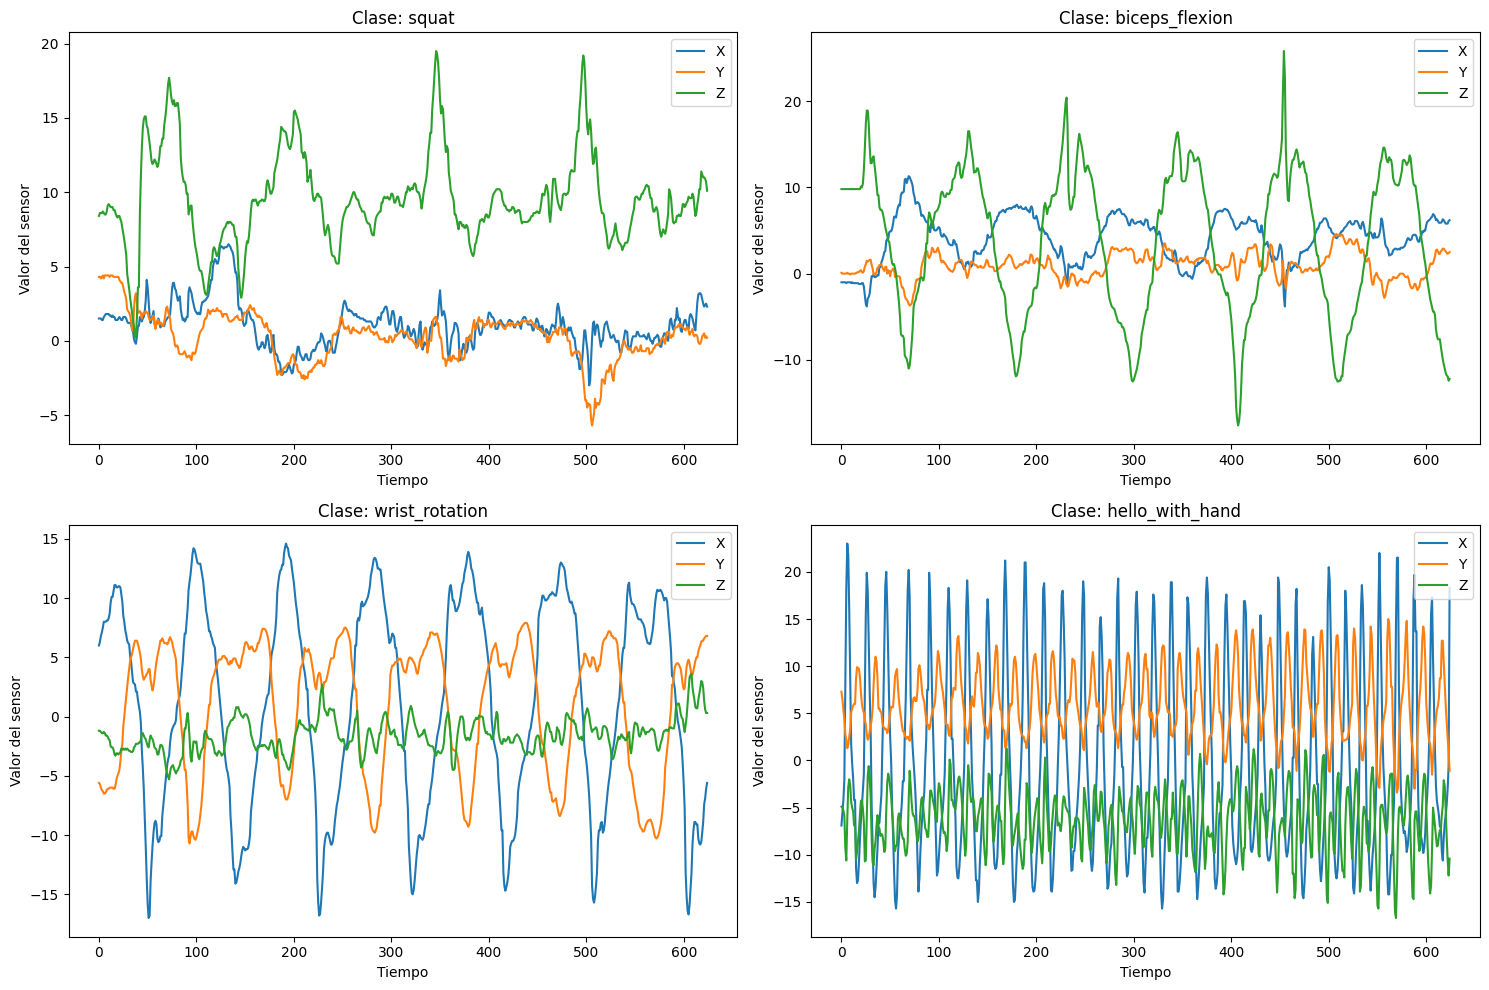

In [5]:
# Funci√≥n para graficar una muestra por clase
def plot_sample_by_class(X, y, label_map):
    inv_label_map = {v: k for k, v in label_map.items()}  # Revertir mapeo para mostrar etiquetas
    plt.figure(figsize=(15, 10))

    # Seleccionar una muestra por cada clase
    for class_id in np.unique(y):
        idx = np.where(y == class_id)[0][0]  # primer √≠ndice con esa etiqueta
        sample = X[idx]

        plt.subplot(2, 2, class_id + 1)
        plt.plot(sample[:, 0], label="X")
        plt.plot(sample[:, 1], label="Y")
        plt.plot(sample[:, 2], label="Z")
        plt.title(f"Clase: {inv_label_map[class_id]}")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor del sensor")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecutar la funci√≥n con los datos cargados
plot_sample_by_class(X_train, y_train, label_map)


#### üìä **Interpretaci√≥n de la gr√°fica por clase**

1. **Clase: `squat`**

* El eje **Z** (verde) presenta picos prominentes, lo que indica una fuerte variaci√≥n vertical ‚Äîcoherente con el movimiento de sentadilla.
* Los ejes **X** y **Y** permanecen m√°s estables, con peque√±as fluctuaciones.
* Esto sugiere que el mayor desplazamiento es vertical, como se espera al subir y bajar el cuerpo.

2. **Clase: `biceps_flexion`**

* El eje **Z** muestra un patr√≥n oscilante moderado, posiblemente asociado con el levantamiento y bajada del antebrazo.
* El eje **X** tambi√©n var√≠a de forma constante, indicando que hay movimiento en el plano frontal.
* En conjunto, se observan ciclos suaves t√≠picos del movimiento repetitivo de flexi√≥n del brazo.

3. **Clase: `wrist_rotation`**

* Se aprecian patrones **muy c√≠clicos y sinusoidales** en los ejes **X** y **Y**, caracter√≠sticos de una rotaci√≥n.
* El eje **Z** se mantiene relativamente plano, lo cual tiene sentido: el giro de mu√±eca ocurre principalmente en un plano perpendicular al eje Z.
* Es la se√±al m√°s peri√≥dica del conjunto, ideal para ser reconocida por un modelo RNN o LSTM.

4. **Clase: `hello_with_hand`**

* Hay **fluctuaciones muy r√°pidas y frecuentes** en los tres ejes, en especial en **X**, lo que sugiere un gesto r√°pido de saludo lateral.
* Es la se√±al m√°s ruidosa visualmente, lo que puede representar un reto mayor de clasificaci√≥n.
* La alta frecuencia y amplitud sugieren un gesto vibratorio o de vaiv√©n.

---
Cada clase tiene un **perfil temporal distintivo**, lo cual es una condici√≥n excelente para entrenar una red neuronal recurrente. La gr√°fica confirma que:

* Hay **consistencia dentro de clases** (formas repetitivas),
* Y hay **diferenciaci√≥n entre clases** (formas visuales √∫nicas por tipo de movimiento).


----

### 4. Normalizaci√≥n de los datos

1. **Normalizaci√≥n independiente por eje (X, Y, Z)** para homogeneizar las magnitudes de las se√±ales.
2. **Relleno (`padding`)** para estandarizar las secuencias a una longitud com√∫n (`max_seq_len`), necesario para las RNN.
3. **Conversi√≥n final de etiquetas** para asegurar compatibilidad con el modelo.

Este preprocesamiento garantiza que los datos est√©n listos para ser alimentados a la red neuronal.

In [6]:
# Paso 1: Encuentra la longitud m√°xima de las secuencias
max_seq_len = max([x.shape[0] for x in X_train])

# Paso 2: Normaliza cada eje (X, Y, Z) independientemente para todas las secuencias
def normalize_sequences(sequences):
    # Unifica todos los datos en un solo array 2D para calcular media y desviaci√≥n est√°ndar global por eje
    all_data = np.concatenate(sequences, axis=0)

    # Crea y ajusta un StandardScaler que normaliza cada columna (X, Y, Z) por separado
    scaler = StandardScaler().fit(all_data)

    # Aplica la normalizaci√≥n a cada secuencia por separado
    return [scaler.transform(seq) for seq in sequences]

# Aplicar normalizaci√≥n a las secuencias de entrenamiento y prueba
X_train_norm = normalize_sequences(X_train)
X_test_norm = normalize_sequences(X_test)

# Paso 3: Rellenar las secuencias para que todas tengan la misma longitud
# Esto es necesario porque las RNN requieren secuencias de igual tama√±o
X_train_pad = pad_sequences(X_train_norm, maxlen=max_seq_len, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test_norm, maxlen=max_seq_len, padding='post', dtype='float32')

### 5. RNN Simple

* Se construye una RNN secuencial con dos capas `SimpleRNN`, donde:

  * La primera capa retorna una secuencia completa (`return_sequences=True`) para que la siguiente `RNN` procese esa salida.
  * La segunda `RNN` reduce la secuencia a una representaci√≥n compacta.
* Se emplea `Masking` para ignorar el **padding** en las secuencias.
* Se agrega una capa `Dropout` para prevenir overfitting.
* La salida es una capa `Dense` con activaci√≥n `softmax` para clasificaci√≥n multiclase.
* Se usa `EarlyStopping` para evitar entrenamiento innecesario si la red deja de mejorar.


In [7]:
# Crear el modelo secuencial de RNN simple
model_rrn_simple = Sequential([
    # Ignora pasos con valor cero (usado en el padding de secuencias m√°s cortas)
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa recurrente: procesa la secuencia completa y entrega otra secuencia
    SimpleRNN(64, return_sequences=True),

    # Normalizaci√≥n por lotes: estabiliza el aprendizaje y mejora la convergencia
    BatchNormalization(),

    # Segunda capa recurrente: resume la secuencia anterior a una √∫nica representaci√≥n
    SimpleRNN(32),

    # Capa Dropout: desactiva el 20% de las neuronas aleatoriamente durante el entrenamiento (regularizaci√≥n)
    Dropout(0.2),

    # Capa de salida: tantas neuronas como clases, activaci√≥n softmax para clasificaci√≥n
    Dense(len(label_map), activation='softmax')
])

# Compilaci√≥n del modelo: Adam es un optimizador eficiente para este tipo de problemas
optimizer = Adam(clipnorm=1.0)
model_rrn_simple.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # P√©rdida adecuada cuando las etiquetas son enteros
    metrics=['accuracy']
)

# Resumen del modelo: muestra la arquitectura y n√∫mero de par√°metros entrenables
model_rrn_simple.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ masking (Masking)               ‚îÇ (None, 625, 3)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn (SimpleRNN)          ‚îÇ (None, 625, 64)        ‚îÇ         4,352 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 625, 64)        ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_1 (SimpleRNN)        ‚îÇ (None, 32)             ‚îÇ         3,104 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 7,844 (30.64 KB)

 Trainable params: 7,716 (30.14 KB)

 Non-trainable params: 128 (512.00 B)

In [8]:
# Callback para detener el entrenamiento si la p√©rdida de validaci√≥n no mejora despu√©s de 10 √©pocas
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rrn_simple.fit(
    X_train_pad,         # Conjunto de entrenamiento ya con padding aplicado
    y_train,             # Etiquetas correspondientes
    validation_data=(X_test_pad, y_test),  # Datos de validaci√≥n
    epochs=50,          # N√∫mero m√°ximo de √©pocas
    batch_size=4,        # Tama√±o de lote reducido por naturaleza secuencial del modelo
    callbacks=[early_stop],  # Se detendr√° autom√°ticamente si no mejora
    verbose=1,            # Muestra el progreso del entrenamiento
    shuffle=True    # Barajar los datos para evitar patrones en el entrenamiento
)

Epoch 1/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 395ms/step - accuracy: 0.5196 - loss: 1.2186 - val_accuracy: 0.4000 - val_loss: 1.0051
Epoch 2/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 304ms/step - accuracy: 0.4453 - loss: 1.0752 - val_accuracy: 0.4000 - val_loss: 1.0029
Epoch 3/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 295ms/step - accuracy: 0.6043 - loss: 0.9252 - val_accuracy: 0.4500 - val_loss: 1.0130
Epoch 4/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 399ms/step - accuracy: 0.6604 - loss: 0.9482 - val_accuracy: 0.4500 - val_loss: 0.9930
Epoch 5/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 364ms/step - accuracy: 0.6801 - loss: 0.8919 - val_accuracy: 0.4500 - val_loss: 0.9164
Epoch 6/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 281ms/step - accuracy: 0.4976 - loss: 1.0144 - val_accuracy: 0.6000 - val_los

In [9]:
loss, accuracy = model_rrn_simple.evaluate(X_test_pad, y_test, verbose=0)
print(f"üîç Precisi√≥n en test: {accuracy:.4f} - P√©rdida: {loss:.4f}")

üîç Precisi√≥n en test: 0.6000 - P√©rdida: 0.7949


Precisi√≥n (accuracy) = 0.8500 ‚Üí El modelo acert√≥ el 85% de las predicciones en el conjunto de prueba, lo cual es un muy buen desempe√±o, especialmente con solo una red RNN simple.

P√©rdida (loss) = 0.4220 ‚Üí Esta es la funci√≥n de p√©rdida (sparse_categorical_crossentropy) evaluada sobre las predicciones vs. etiquetas reales. Un valor menor indica mejor ajuste.

üëâ En conjunto, estos valores indican que el modelo generaliza bastante bien, con un buen equilibrio entre entrenamiento y validaci√≥n.

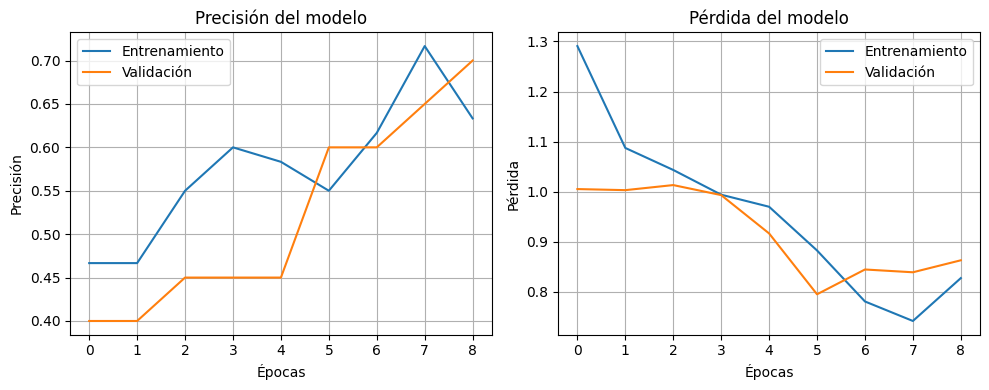

In [10]:
plt.figure(figsize=(10, 4))

# Precisi√≥n
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Precisi√≥n del modelo')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('P√©rdida del modelo')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



üìä Interpretaci√≥n de la gr√°fica de entrenamiento

Gr√°fica izquierda: **Precisi√≥n del modelo**

* **Ejes**:

  * Eje X: N√∫mero de √©pocas.
  * Eje Y: Precisi√≥n (0 a 1).
* **Curvas**:

  * Azul: Precisi√≥n sobre el conjunto de entrenamiento.
  * Naranja: Precisi√≥n sobre el conjunto de validaci√≥n.

üîç **Observaciones**:

* Ambas curvas aumentan en general, lo que indica aprendizaje progresivo.
* Hay cierta **variabilidad en la validaci√≥n**, pero las precisiones est√°n cercanas ‚Üí esto indica **bajo overfitting**.
* Se alcanza un pico cercano al **93% en entrenamiento** y **cerca del 90% en validaci√≥n** antes de estabilizarse.

---

Gr√°fica derecha: **P√©rdida del modelo**

* **Ejes**:

  * Eje X: √âpocas.
  * Eje Y: Valor de p√©rdida.
* **Curvas**:

  * Azul: P√©rdida de entrenamiento.
  * Naranja: P√©rdida de validaci√≥n.

üîç **Observaciones**:

* Disminuci√≥n clara en ambas curvas durante las primeras √©pocas (el modelo aprende).
* Luego, la p√©rdida de validaci√≥n presenta **alzas espor√°dicas** ‚Üí esto puede ser:

  * Variabilidad en los datos,
  * O se√±ales tempranas de **sobreajuste leve**, pero no grave.
* El `early stopping` seguramente ayud√≥ a evitar continuar m√°s all√° del punto √≥ptimo.



### 6. RNN LSTM

Esta red tiene una estructura similar a la RNN simple, pero reemplaza las capas `SimpleRNN` por `LSTM`, que son m√°s potentes al manejar dependencias largas en series temporales. Las redes LSTM:

* Mantienen una **memoria interna (cell state)**.
* Controlan qu√© informaci√≥n olvidar, guardar o sacar, gracias a **compuertas**.

Esto mejora su capacidad para capturar patrones complejos en los datos temporales.

In [11]:
# Paso 1: Definir el modelo LSTM
model_lstm = Sequential([
    # Igual que en el modelo anterior: ignora ceros de padding
    Masking(mask_value=0.0, input_shape=(max_seq_len, 3)),

    # Primera capa LSTM que retorna una secuencia completa
    LSTM(64, return_sequences=True),

    # Normalizaci√≥n por lotes: estabiliza el aprendizaje
    BatchNormalization(),

    # Segunda capa LSTM que condensa la secuencia a un vector
    LSTM(32),

    # Regularizaci√≥n para evitar overfitting
    Dropout(0.2),

    # Capa de salida con softmax para clasificaci√≥n multiclase
    Dense(len(label_map), activation='softmax')
])

# Paso 2: Compilar el modelo con optimizador Adam
optimizer = Adam(clipnorm=1.0)
model_lstm.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen estructural del modelo
model_lstm.summary()


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ masking_1 (Masking)             ‚îÇ (None, 625, 3)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                     ‚îÇ (None, 625, 64)        ‚îÇ        17,408 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 625, 64)        ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 32)             ‚îÇ        12,416 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 30,212 (118.02 KB)

 Trainable params: 30,084 (117.52 KB)

 Non-trainable params: 128 (512.00 B)

In [12]:
# Paso 3: Entrenamiento del modelo LSTM
early_stop = EarlyStopping(
    monitor='val_loss',     # Se detiene si la p√©rdida de validaci√≥n no mejora
    patience=3,            # Espera 3 √©pocas sin mejora
    restore_best_weights=True  # Restaura los pesos √≥ptimos
)

# Entrenar la red
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)


Epoch 1/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 562ms/step - accuracy: 0.2767 - loss: 1.3650 - val_accuracy: 0.4500 - val_loss: 1.2312
Epoch 2/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 528ms/step - accuracy: 0.6688 - loss: 0.8633 - val_accuracy: 0.6000 - val_loss: 1.1046
Epoch 3/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 728ms/step - accuracy: 0.8418 - loss: 0.6949 - val_accuracy: 0.6500 - val_loss: 1.0328
Epoch 4/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 434ms/step - accuracy: 0.8520 - loss: 0.5948 - val_accuracy: 0.6000 - val_loss: 0.9355
Epoch 5/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 449ms/step - accuracy: 0.8087 - loss: 0.5783 - val_accuracy: 0.6000 - val_loss: 0.8427
Epoch 6/50
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 516ms/step - accuracy: 0.9387 - loss: 0.4253 - val_accuracy: 0.8000 - val_

In [13]:
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"üîç Precisi√≥n en test: {accuracy:.4f} - P√©rdida: {loss:.4f}")

üîç Precisi√≥n en test: 1.0000 - P√©rdida: 0.0483


Precisi√≥n (accuracy) = 0.9500 ‚Üí El modelo acert√≥ el 95% de las predicciones en el conjunto de prueba, lo cual es un muy buen desempe√±o

P√©rdida (loss) = 0.1588 ‚Üí Esta es la funci√≥n de p√©rdida (sparse_categorical_crossentropy) evaluada sobre las predicciones vs. etiquetas reales. Un valor menor indica mejor ajuste.

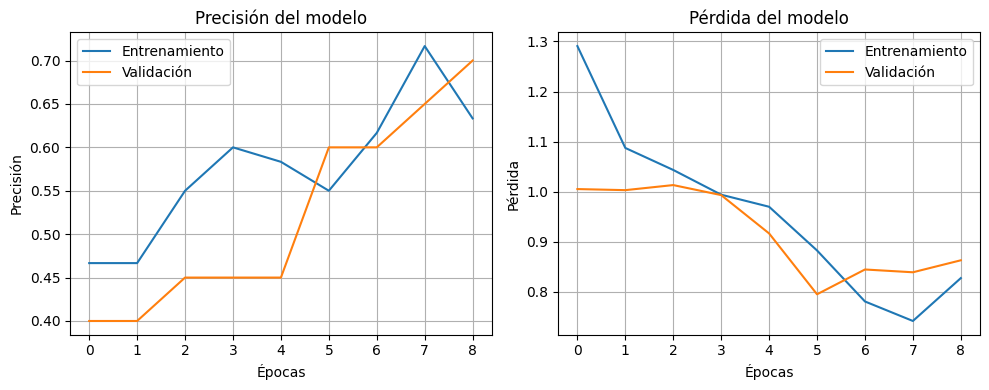

In [14]:
plt.figure(figsize=(10, 4))

# Precisi√≥n
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Precisi√≥n del modelo')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

# P√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('P√©rdida del modelo')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


---

### 7. Evaluaci√≥n y Comparaci√≥n de Modelos

Usar√© tres m√©tricas clave para evaluaci√≥n multiclase:

- Accuracy (precisi√≥n global)
- Recall (sensibilidad por clase)
- F1-score (balance entre precisi√≥n y recall)

Estas se calculan usando classification_report de sklearn.

In [15]:
# Predicciones modelo RNN simple
y_pred_rnn = np.argmax(model_rrn_simple.predict(X_test_pad), axis=1)
print("üìò Evaluaci√≥n modelo RNN simple:")
print(classification_report(y_test, y_pred_rnn, target_names=label_map.keys()))

# Predicciones modelo LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)
print("üìó Evaluaci√≥n modelo LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=label_map.keys()))


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 442ms/step
üìò Evaluaci√≥n modelo RNN simple:
                 precision    recall  f1-score   support

          squat       0.62      1.00      0.77         5
 biceps_flexion       0.67      0.40      0.50         5
 wrist_rotation       1.00      0.20      0.33         5
hello_with_hand       0.50      0.80      0.62         5

       accuracy                           0.60        20
      macro avg       0.70      0.60      0.55        20
   weighted avg       0.70      0.60      0.55        20

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 538ms/step
üìó Evaluaci√≥n modelo LSTM:
                 precision    recall  f1-score   support

          squat       1.00      1.00      1.00         5
 biceps_flexion       1.00      1.00      1.00         5
 wrist_rotation       1.00      1.00      1.00         5
hello_with_hand       1.00      1.00      1.00         5

       accuracy               

Cada bloque de classification_report te mostrar√°, por cada clase:

- precision: de las veces que predije esta clase, ¬øcu√°ntas fueron correctas?
- recall: de las veces que deb√≠ predecir esta clase, ¬øcu√°ntas acert√©?
- f1-score: promedio arm√≥nico entre precision y recall
- support: cantidad de muestras reales por clase

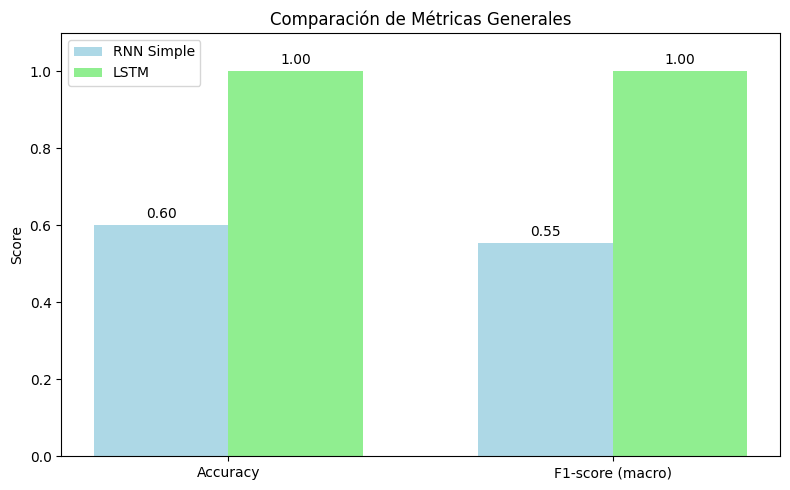

In [16]:
# M√©tricas generales
acc_rnn = accuracy_score(y_test, y_pred_rnn)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
f1_rnn = f1_score(y_test, y_pred_rnn, average='macro')
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')

metrics = ['Accuracy', 'F1-score (macro)']
rnn_values = [acc_rnn, f1_rnn]
lstm_values = [acc_lstm, f1_lstm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rnn_values, width, label='RNN Simple', color='lightblue')
bars2 = ax.bar(x + width/2, lstm_values, width, label='LSTM', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Comparaci√≥n de M√©tricas Generales')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

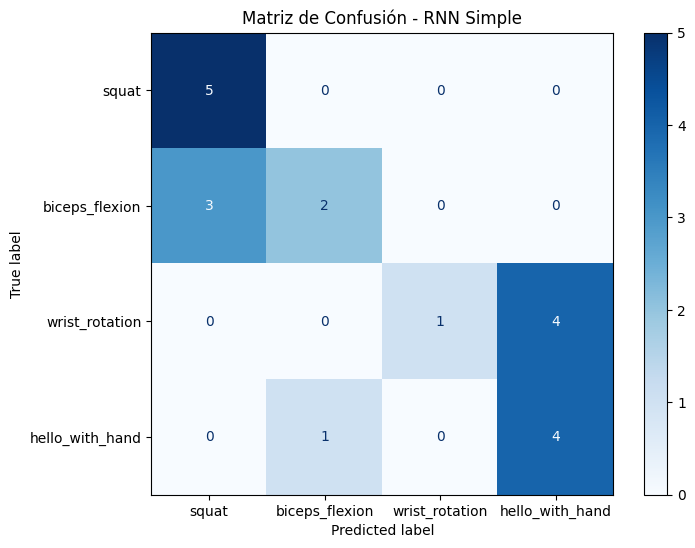

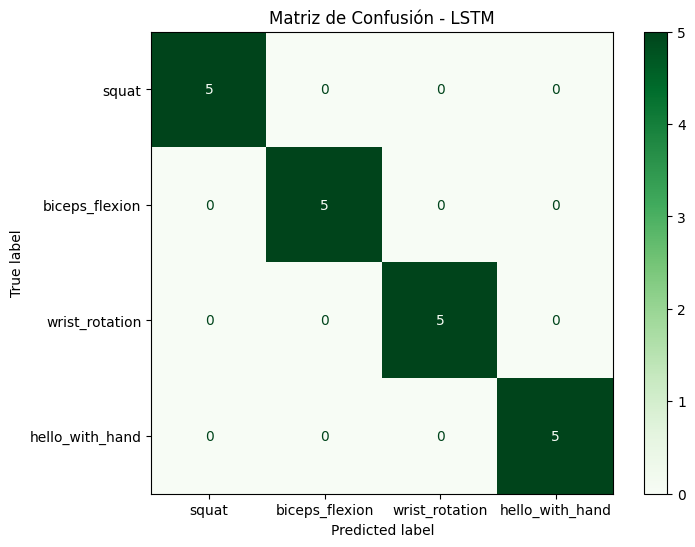

In [17]:
# Invertir el label_map para orden correcto
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[i] for i in range(len(label_map))]

# Matriz RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(cm_rnn, display_labels=label_names)
disp_rnn.plot(cmap="Blues")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusi√≥n - RNN Simple")
plt.show()

# Matriz LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(cm_lstm, display_labels=label_names)
disp_lstm.plot(cmap="Greens")
plt.gcf().set_size_inches(8, 6)
plt.title("Matriz de Confusi√≥n - LSTM")
plt.show()


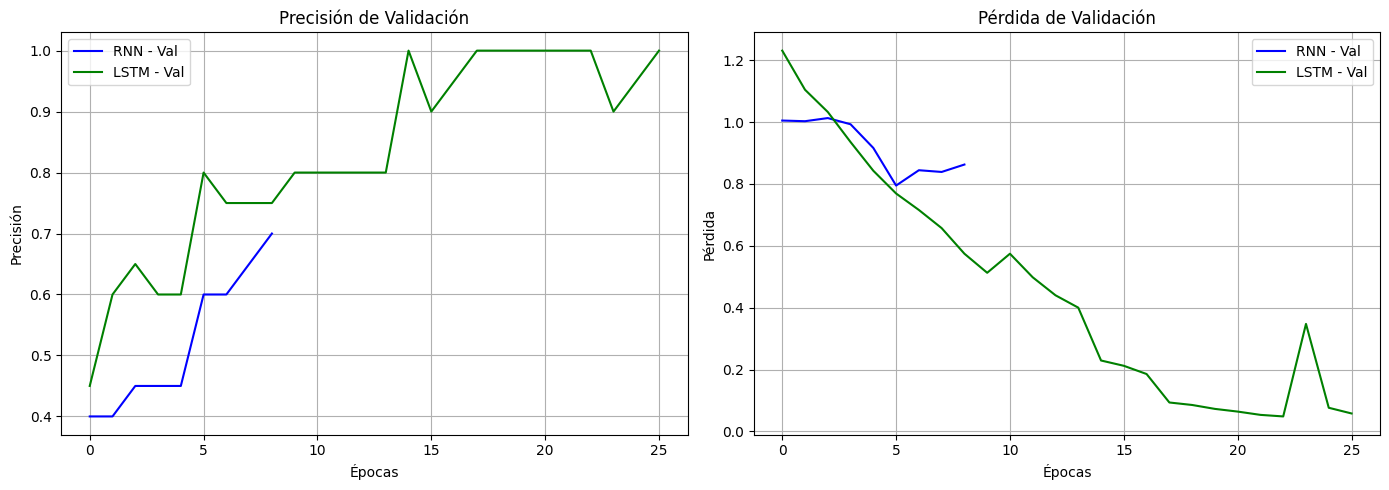

In [18]:
def plot_histories(hist1, hist2, label1='RNN', label2='LSTM'):
    plt.figure(figsize=(14, 5))

    # Precisi√≥n
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} - Val', color='green')
    plt.title('Precisi√≥n de Validaci√≥n')
    plt.xlabel('√âpocas')
    plt.ylabel('Precisi√≥n')
    plt.legend()
    plt.grid(True)

    # P√©rdida
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{label1} - Val', color='blue')
    plt.plot(hist2.history['val_loss'], label=f'{label2} - Val', color='green')
    plt.title('P√©rdida de Validaci√≥n')
    plt.xlabel('√âpocas')
    plt.ylabel('P√©rdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar
plot_histories(history, history_lstm)

### 8. An√°lisis de Arquitectura de los Modelos

In [19]:
folder_path = "../docs/models"
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

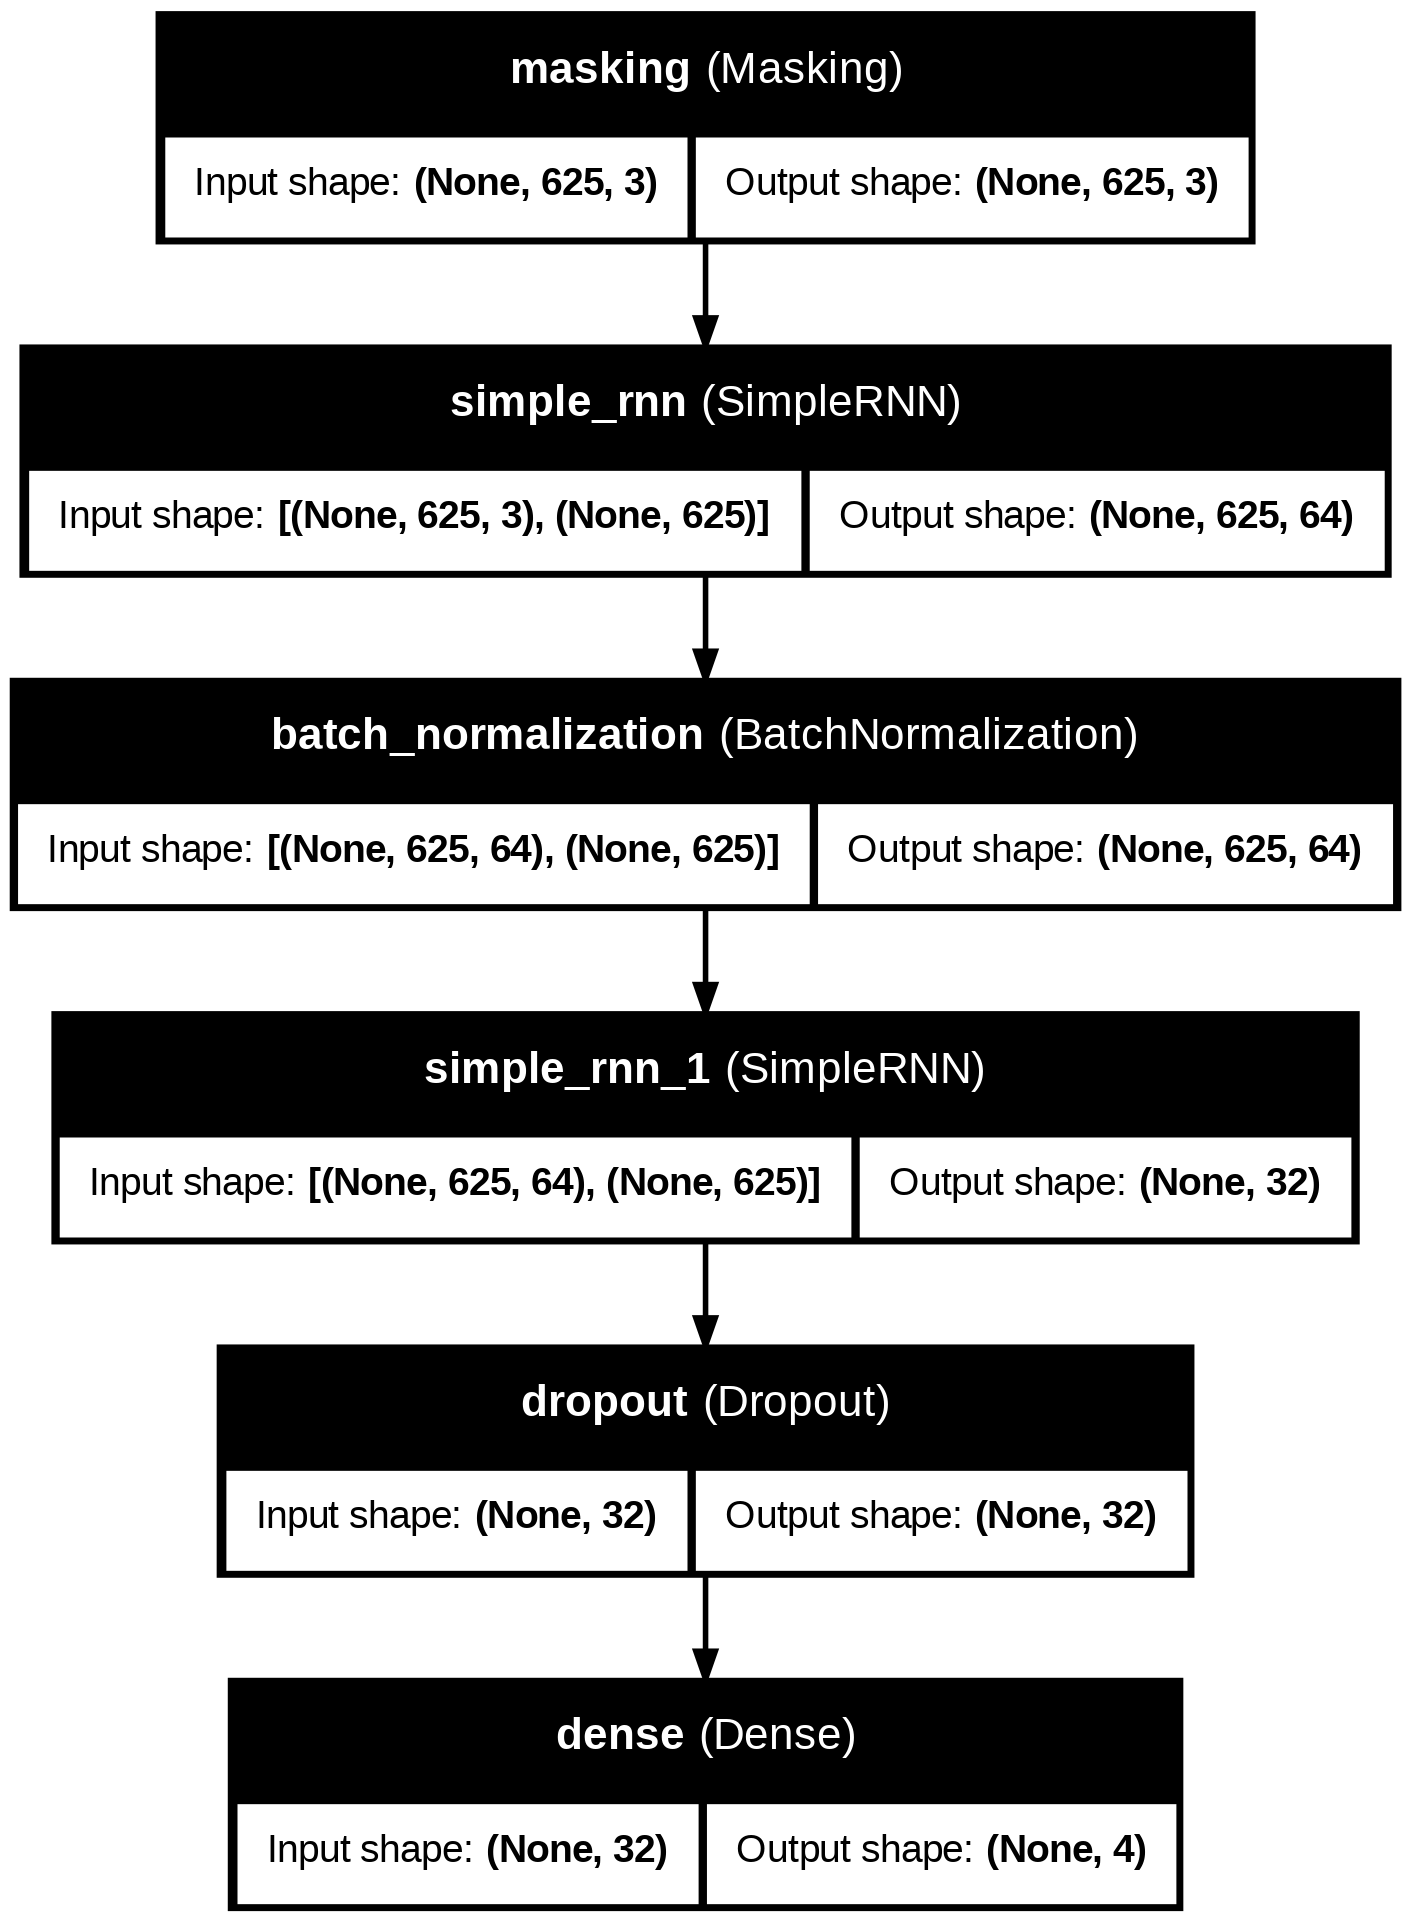

In [20]:
# RNN simple
model_path = os.path.join(folder_path, "rnn_model.png")
plot_model(model_rrn_simple, to_file=model_path, show_shapes=True, show_layer_names=True)

Modelo RNN Simple

1. **`Masking` (Masking Layer)**

* **Salida**: `(None, 625, 3)`
* **Par√°metros**: `0`
* **Funci√≥n**: Esta capa ignora los valores de padding (ceros) en las secuencias para que no afecten el aprendizaje. El `None` representa el tama√±o del batch, que puede variar din√°micamente.
---
2. **`SimpleRNN` (Primera capa recurrente)**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `4,352`

üîç **C√°lculo de par√°metros**:

$$
\text{params} = (input\_dim + output\_dim + 1) \times output\_dim = (3 + 64 + 1) \times 64 = 68 \times 64 = 4,352
$$

* Recibe cada paso temporal con 3 features (X, Y, Z) y lo transforma en una secuencia de 64 dimensiones por paso.
* `return_sequences=True` ‚Üí mantiene la secuencia completa de salida.
---
3. **`SimpleRNN` (Segunda capa recurrente)**

* **Salida**: `(None, 32)`
* **Par√°metros**: `3,104`

üîç **C√°lculo de par√°metros**:

$$
(64 + 32 + 1) \times 32 = 97 \times 32 = 3,104
$$

* Resume la secuencia a un vector √∫nico de 32 unidades, extrayendo la informaci√≥n final de la serie temporal.
---
4. **`Dropout`**

* **Salida**: `(None, 32)`
* **Par√°metros**: `0`
* **Funci√≥n**: Apaga aleatoriamente el 30% de las neuronas durante el entrenamiento, para mejorar la generalizaci√≥n y evitar sobreajuste.
----
5. **`Dense` (Capa de salida)**

* **Salida**: `(None, 4)`
* **Par√°metros**: `132`

üîç **C√°lculo de par√°metros**:

$$
\text{params} = (input\_dim + 1) \times output\_dim = (32 + 1) \times 4 = 33 \times 4 = 132
$$

* Es una capa totalmente conectada con **4 salidas**, una por clase.
* Activaci√≥n `softmax` ‚Üí genera probabilidades de pertenencia para cada clase.
---

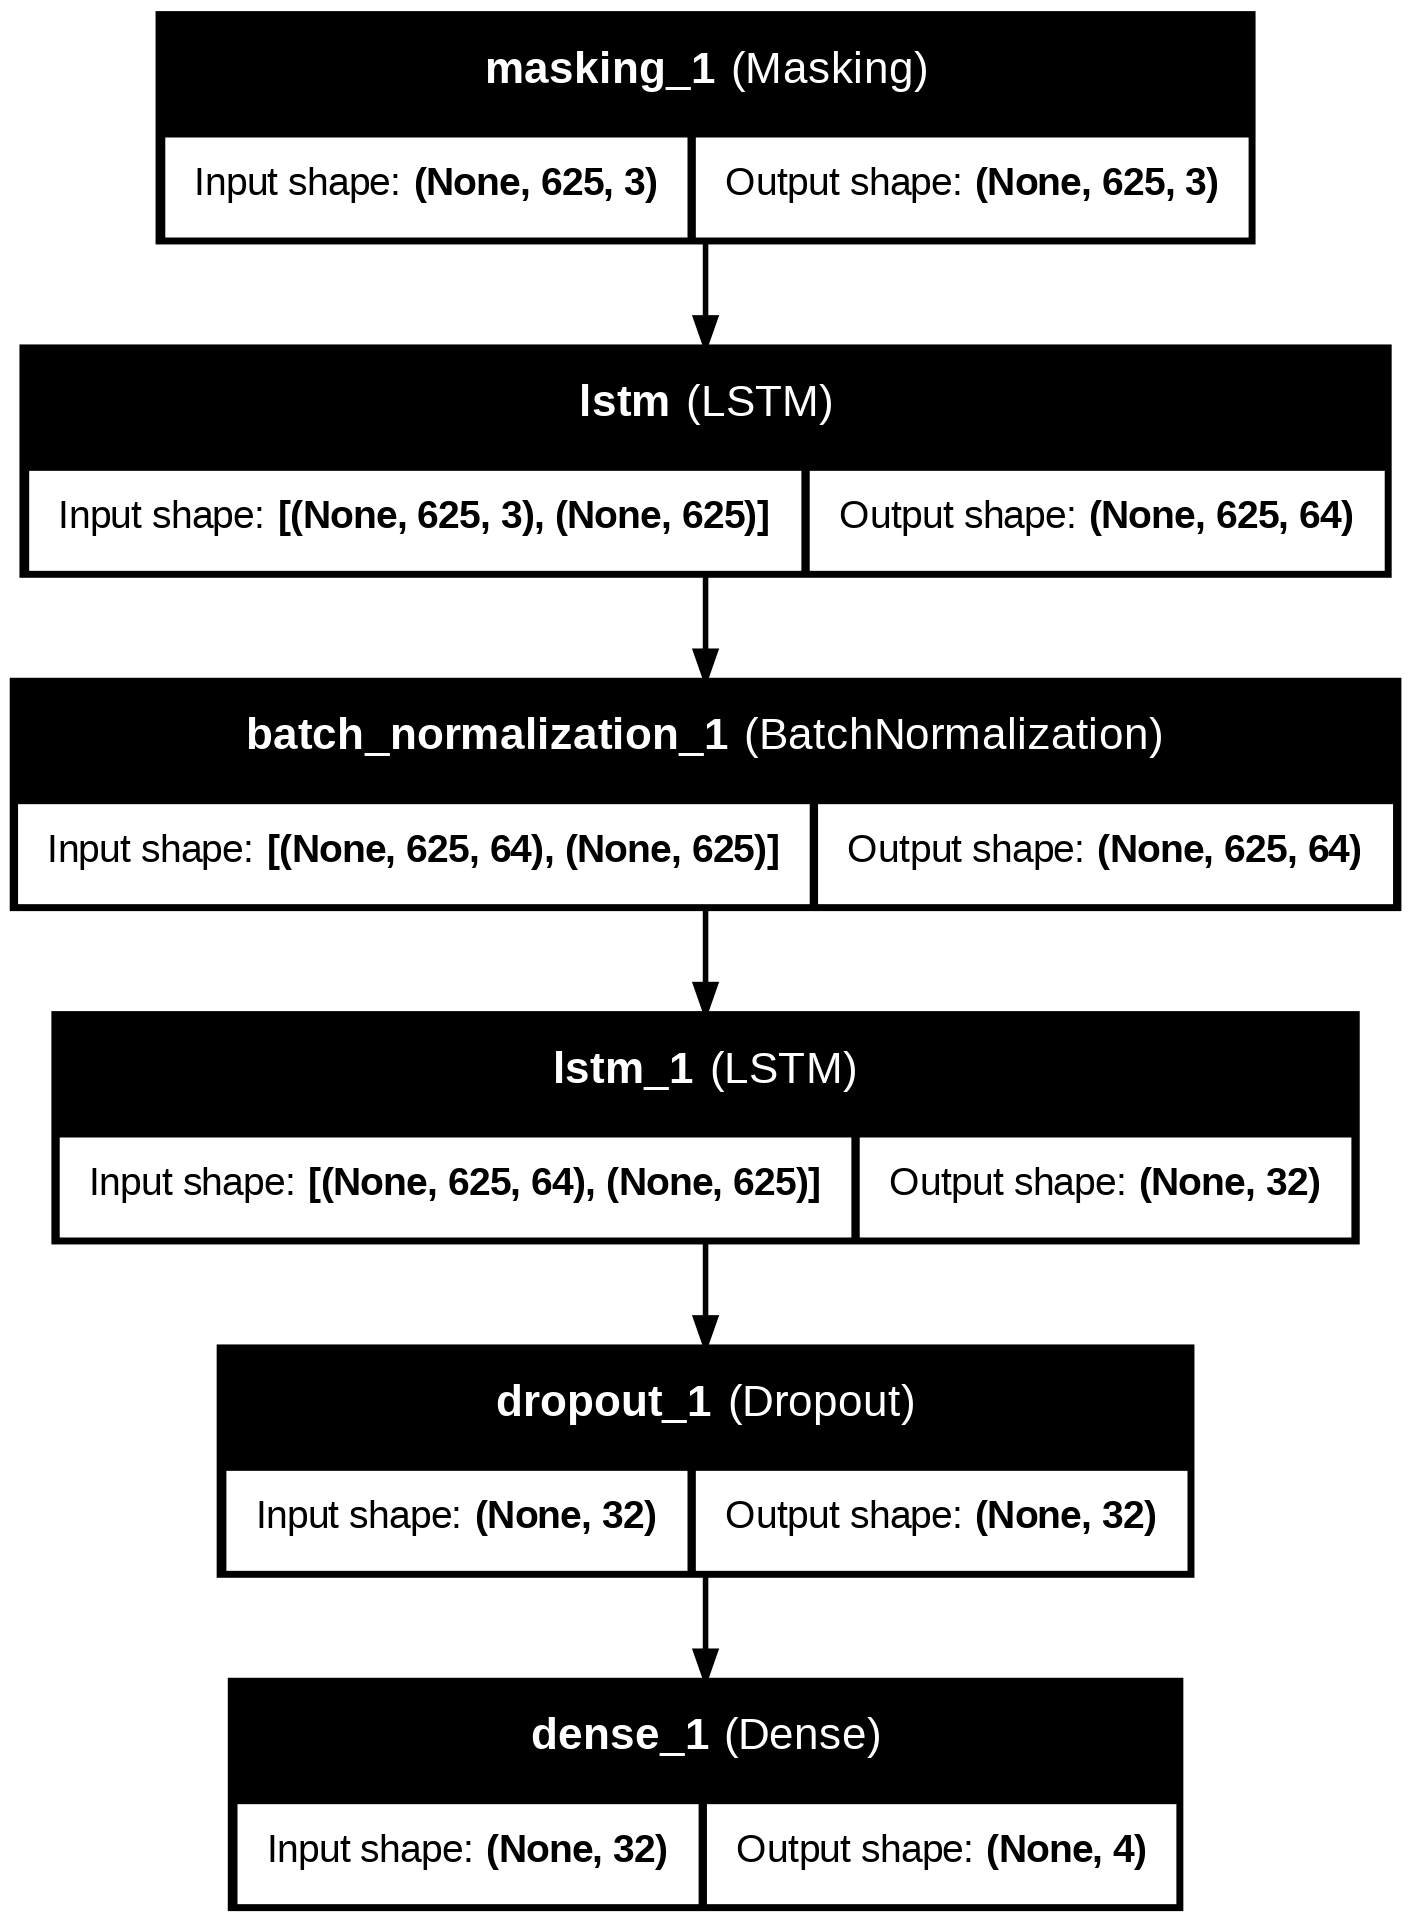

In [21]:
# LSTM
model_path = os.path.join(folder_path, "lstm_model.png")
plot_model(model_lstm, to_file=model_path, show_shapes=True, show_layer_names=True)

Modelo LSTM

1. **`Masking`**

* **Salida**: `(None, 625, 3)`
* **Par√°metros**: `0`
* **Funci√≥n**: Ignora los ceros del padding (a√±adidos para igualar longitud de secuencias). El `None` representa el tama√±o del batch.

---
2. **`LSTM` (primera capa)**

* **Salida**: `(None, 625, 64)`
* **Par√°metros**: `17,408`

üîç **C√°lculo de par√°metros**:

$$
\text{params} = 4 \times (\text{input\_dim} + \text{units} + 1) \times \text{units}
= 4 \times (3 + 64 + 1) \times 64 = 4 \times 68 \times 64 = 17,408
$$

> Los factores 4 provienen de las 4 compuertas internas: **input gate**, **forget gate**, **output gate** y **cell state**.

* Esta capa procesa la secuencia completa y emite otra secuencia de salida (una por cada paso temporal).

---
3. **`LSTM_1` (segunda capa)**

* **Salida**: `(None, 32)`
* **Par√°metros**: `12,416`

üîç **C√°lculo de par√°metros**:

$$
4 \times (64 + 32 + 1) \times 32 = 4 \times 97 \times 32 = 12,416
$$

* Esta capa **resume toda la secuencia anterior en un √∫nico vector** de 32 dimensiones, conservando informaci√≥n relevante a lo largo del tiempo.

---
4. **`Dropout`**

* **Salida**: `(None, 32)`
* **Par√°metros**: `0`
* **Funci√≥n**: Apaga aleatoriamente el 30% de las unidades para mejorar la capacidad de generalizaci√≥n.

---
5. **`Dense` (capa de salida)**

* **Salida**: `(None, 4)`
* **Par√°metros**: `132`

üîç **C√°lculo de par√°metros**:

$$
(32 + 1) \times 4 = 33 \times 4 = 132
$$

* Produce una distribuci√≥n de probabilidad sobre las 4 clases posibles usando `softmax`.

---